In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from matplotlib.patches import Rectangle

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

sys.path.append("../")
from data import gestalt

%load_ext autoreload
%autoreload 2

In [2]:
dataset = gestalt.Gestalt(passes=["images", "bounding_boxes", "masks", "normals"])
batch = dataset.__getitem__(100)

34526 # training scenes, 3832 # test scenes


In [3]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


In [4]:
model = get_model_instance_segmentation(2)

# MaskRCNN Pre-Trained

First, let's see how the model runs out of the box. Then, we'll fine-tune it on our dataset and observe how it's improved.

In [28]:
def plot(images, pred_boxes, masks, normals):
    fig, ax = plt.subplots(len(images), 3, figsize=(20, 40))
    for i in range(images.shape[0]):

        ax[i, 1].imshow(images[i].transpose(1, 2, 0), cmap="gray")
        ax[i, 2].imshow(images[i].transpose(1, 2, 0), cmap="gray")

        for mask in masks[i]:
            ax[i, 2].imshow((mask > 0.5).transpose(1, 2, 0), interpolation='none', cmap='jet', alpha=0.5)
            
        for box in pred_boxes[i]:
            xy = (box[0], box[1])
            h, w = box[2] - box[0], box[3] - box[1]
            rect = Rectangle(xy, h, w, linewidth=5, edgecolor="r", facecolor="none", alpha=0.5)
            ax[i, 2].add_patch(rect)
            
        ax[i, 0].imshow(normals[i])
    
    ax[0, 0].set_title("Surface Normals")
    ax[0, 1].set_title("Input Image")
    ax[0, 2].set_title("MaskRCNN Bounding Boxes + Mask")
    
    plt.show()

# Mask R-CNN Fine Tuned

Now let's fine tune our model and see how it does

In [6]:
from engine import train_one_epoch, evaluate
import utils


def main(model):
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = gestalt.Gestalt(root_dir="/om2/user/yyf/CommonFate/scenes",
                              frames_per_scene=1, top_level=["train_voronoi", "train_noise"], 
                              sub_level=["superquadric_2", "superquadric_3"],
                              passes=["images", "bounding_boxes"])

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=1,
        collate_fn=utils.collate_fn)

    

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [7]:
# get the model using our helper function
num_classes = 2
fine_tune_maskrcnn = get_model_instance_segmentation(num_classes)

main(fine_tune_maskrcnn)


34525 # training scenes, 3832 # test scenes
/om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_3/scene_1115/masks/Image0006.png 

/om2/user/yyf/miniconda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


INCORRECT MASKS
area 0 coords ((5, 108), (6, 109))
Epoch: [0]  [      0/1104775]  eta: 19 days, 2:50:29  lr: 0.000010  loss: 3.7197 (3.7197)  loss_classifier: 0.7989 (0.7989)  loss_box_reg: 0.1546 (0.1546)  loss_mask: 2.6709 (2.6709)  loss_objectness: 0.0741 (0.0741)  loss_rpn_box_reg: 0.0213 (0.0213)  time: 1.4952  data: 0.6404  max mem: 1640
Epoch: [0]  [     10/1104775]  eta: 4 days, 2:48:59  lr: 0.000060  loss: 3.0170 (3.2513)  loss_classifier: 0.7093 (0.6946)  loss_box_reg: 0.1546 (0.1712)  loss_mask: 1.7833 (1.9635)  loss_objectness: 0.1931 (0.3647)  loss_rpn_box_reg: 0.0180 (0.0575)  time: 0.3220  data: 0.0633  max mem: 1916
Epoch: [0]  [     20/1104775]  eta: 3 days, 9:58:45  lr: 0.000110  loss: 2.2802 (2.6139)  loss_classifier: 0.4652 (0.5302)  loss_box_reg: 0.1419 (0.1668)  loss_mask: 1.3415 (1.6051)  loss_objectness: 0.1329 (0.2719)  loss_rpn_box_reg: 0.0152 (0.0398)  time: 0.2057  data: 0.0058  max mem: 1916
Epoch: [0]  [     30/1104775]  eta: 3 days, 3:37:28  lr: 0.000160 

Epoch: [0]  [    260/1104775]  eta: 2 days, 16:35:16  lr: 0.001309  loss: 0.8643 (1.0986)  loss_classifier: 0.1434 (0.1892)  loss_box_reg: 0.2121 (0.2137)  loss_mask: 0.4125 (0.5809)  loss_objectness: 0.0240 (0.0941)  loss_rpn_box_reg: 0.0081 (0.0208)  time: 0.2071  data: 0.0053  max mem: 2086
Epoch: [0]  [    270/1104775]  eta: 2 days, 16:33:01  lr: 0.001359  loss: 0.8023 (1.0877)  loss_classifier: 0.1430 (0.1875)  loss_box_reg: 0.2121 (0.2132)  loss_mask: 0.3871 (0.5753)  loss_objectness: 0.0198 (0.0914)  loss_rpn_box_reg: 0.0073 (0.0203)  time: 0.2085  data: 0.0052  max mem: 2086
/om2/user/yyf/CommonFate/scenes/train_noise/superquadric_2/scene_3453/masks/Image0025.png INCORRECT MASKS
area 0 coords ((58, 73), (59, 74))
Epoch: [0]  [    280/1104775]  eta: 2 days, 16:30:23  lr: 0.001409  loss: 0.7665 (1.0809)  loss_classifier: 0.1270 (0.1852)  loss_box_reg: 0.1795 (0.2116)  loss_mask: 0.3660 (0.5686)  loss_objectness: 0.0231 (0.0944)  loss_rpn_box_reg: 0.0073 (0.0212)  time: 0.2068  da

Epoch: [0]  [    520/1104775]  eta: 2 days, 16:01:43  lr: 0.002602  loss: 0.6682 (0.9094)  loss_classifier: 0.0941 (0.1520)  loss_box_reg: 0.1466 (0.1909)  loss_mask: 0.3827 (0.4785)  loss_objectness: 0.0357 (0.0706)  loss_rpn_box_reg: 0.0080 (0.0174)  time: 0.2060  data: 0.0056  max mem: 2086
Epoch: [0]  [    530/1104775]  eta: 2 days, 16:00:55  lr: 0.002652  loss: 0.6413 (0.9039)  loss_classifier: 0.0813 (0.1506)  loss_box_reg: 0.1347 (0.1898)  loss_mask: 0.3399 (0.4758)  loss_objectness: 0.0265 (0.0703)  loss_rpn_box_reg: 0.0079 (0.0174)  time: 0.2064  data: 0.0056  max mem: 2086
Epoch: [0]  [    540/1104775]  eta: 2 days, 16:01:04  lr: 0.002702  loss: 0.6433 (0.9028)  loss_classifier: 0.0886 (0.1502)  loss_box_reg: 0.1391 (0.1897)  loss_mask: 0.3399 (0.4761)  loss_objectness: 0.0231 (0.0696)  loss_rpn_box_reg: 0.0079 (0.0172)  time: 0.2079  data: 0.0055  max mem: 2086
Epoch: [0]  [    550/1104775]  eta: 2 days, 16:01:47  lr: 0.002752  loss: 0.6766 (0.8986)  loss_classifier: 0.1032 

/om2/user/yyf/CommonFate/scenes/train_noise/superquadric_2/scene_7648/masks/Image0006.png INCORRECT MASKS
area 0 coords ((126, 7), (127, 8))
Epoch: [0]  [    780/1104775]  eta: 2 days, 15:56:10  lr: 0.003896  loss: 0.5172 (0.8308)  loss_classifier: 0.0757 (0.1361)  loss_box_reg: 0.1217 (0.1801)  loss_mask: 0.2540 (0.4348)  loss_objectness: 0.0358 (0.0630)  loss_rpn_box_reg: 0.0063 (0.0168)  time: 0.2065  data: 0.0062  max mem: 2104
Epoch: [0]  [    790/1104775]  eta: 2 days, 15:55:41  lr: 0.003946  loss: 0.6219 (0.8283)  loss_classifier: 0.0791 (0.1353)  loss_box_reg: 0.1239 (0.1794)  loss_mask: 0.3266 (0.4342)  loss_objectness: 0.0420 (0.0628)  loss_rpn_box_reg: 0.0079 (0.0167)  time: 0.2047  data: 0.0058  max mem: 2104
Epoch: [0]  [    800/1104775]  eta: 2 days, 15:54:22  lr: 0.003996  loss: 0.5757 (0.8252)  loss_classifier: 0.0744 (0.1345)  loss_box_reg: 0.1216 (0.1786)  loss_mask: 0.3351 (0.4331)  loss_objectness: 0.0383 (0.0625)  loss_rpn_box_reg: 0.0052 (0.0166)  time: 0.2047  da

area 0 coords ((70, 62), (71, 63))
Epoch: [0]  [   1030/1104775]  eta: 2 days, 15:51:28  lr: 0.005000  loss: 0.7910 (0.7884)  loss_classifier: 0.1106 (0.1268)  loss_box_reg: 0.1550 (0.1728)  loss_mask: 0.4134 (0.4118)  loss_objectness: 0.0322 (0.0604)  loss_rpn_box_reg: 0.0083 (0.0166)  time: 0.2081  data: 0.0058  max mem: 2109
Epoch: [0]  [   1040/1104775]  eta: 2 days, 15:50:31  lr: 0.005000  loss: 0.7206 (0.7870)  loss_classifier: 0.0910 (0.1264)  loss_box_reg: 0.1427 (0.1724)  loss_mask: 0.4134 (0.4112)  loss_objectness: 0.0454 (0.0603)  loss_rpn_box_reg: 0.0101 (0.0165)  time: 0.2054  data: 0.0061  max mem: 2109
Epoch: [0]  [   1050/1104775]  eta: 2 days, 15:50:15  lr: 0.005000  loss: 0.6456 (0.7871)  loss_classifier: 0.0978 (0.1262)  loss_box_reg: 0.1427 (0.1722)  loss_mask: 0.3989 (0.4114)  loss_objectness: 0.0357 (0.0606)  loss_rpn_box_reg: 0.0080 (0.0166)  time: 0.2050  data: 0.0057  max mem: 2109
Epoch: [0]  [   1060/1104775]  eta: 2 days, 15:49:53  lr: 0.005000  loss: 0.6456

/om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_3/scene_4151/masks/Image0062.png INCORRECT MASKS
area 0 coords ((43, 48), (44, 49))
Epoch: [0]  [   1300/1104775]  eta: 2 days, 15:53:20  lr: 0.005000  loss: 0.5778 (0.7615)  loss_classifier: 0.0849 (0.1219)  loss_box_reg: 0.1634 (0.1699)  loss_mask: 0.2662 (0.3988)  loss_objectness: 0.0101 (0.0555)  loss_rpn_box_reg: 0.0055 (0.0155)  time: 0.2107  data: 0.0056  max mem: 2183
/om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_3/scene_5948/masks/Image0063.png INCORRECT MASKS
area 0 coords ((70, 79), (71, 80))
Epoch: [0]  [   1310/1104775]  eta: 2 days, 15:53:24  lr: 0.005000  loss: 0.5778 (0.7614)  loss_classifier: 0.0902 (0.1216)  loss_box_reg: 0.1538 (0.1696)  loss_mask: 0.2917 (0.3981)  loss_objectness: 0.0173 (0.0563)  loss_rpn_box_reg: 0.0069 (0.0157)  time: 0.2111  data: 0.0057  max mem: 2183
Epoch: [0]  [   1320/1104775]  eta: 2 days, 15:52:49  lr: 0.005000  loss: 0.5571 (0.7605)  loss_classifier: 0.0798 (0.1213) 

Epoch: [0]  [   1570/1104775]  eta: 2 days, 15:53:27  lr: 0.005000  loss: 0.6029 (0.7346)  loss_classifier: 0.0982 (0.1166)  loss_box_reg: 0.1541 (0.1657)  loss_mask: 0.2947 (0.3838)  loss_objectness: 0.0163 (0.0532)  loss_rpn_box_reg: 0.0068 (0.0153)  time: 0.2090  data: 0.0055  max mem: 2183
Epoch: [0]  [   1580/1104775]  eta: 2 days, 15:53:09  lr: 0.005000  loss: 0.6004 (0.7339)  loss_classifier: 0.1055 (0.1165)  loss_box_reg: 0.1381 (0.1655)  loss_mask: 0.3027 (0.3837)  loss_objectness: 0.0278 (0.0531)  loss_rpn_box_reg: 0.0059 (0.0152)  time: 0.2076  data: 0.0053  max mem: 2183
Epoch: [0]  [   1590/1104775]  eta: 2 days, 15:52:59  lr: 0.005000  loss: 0.6004 (0.7335)  loss_classifier: 0.0936 (0.1163)  loss_box_reg: 0.1339 (0.1653)  loss_mask: 0.3249 (0.3837)  loss_objectness: 0.0244 (0.0529)  loss_rpn_box_reg: 0.0053 (0.0152)  time: 0.2068  data: 0.0056  max mem: 2183
/om2/user/yyf/CommonFate/scenes/train_noise/superquadric_2/scene_3526/masks/Image0013.png INCORRECT MASKS
area 0 co

returning empty boxes for scene /om2/user/yyf/CommonFate/scenes/train_noise/superquadric_2/scene_2110/masks/Image0018.png
Epoch: [0]  [   1830/1104775]  eta: 2 days, 15:51:36  lr: 0.005000  loss: 0.5565 (0.7105)  loss_classifier: 0.0887 (0.1125)  loss_box_reg: 0.1453 (0.1618)  loss_mask: 0.2725 (0.3715)  loss_objectness: 0.0223 (0.0500)  loss_rpn_box_reg: 0.0066 (0.0147)  time: 0.2099  data: 0.0055  max mem: 2183
Epoch: [0]  [   1840/1104775]  eta: 2 days, 15:49:34  lr: 0.005000  loss: 0.5565 (0.7095)  loss_classifier: 0.0868 (0.1123)  loss_box_reg: 0.1357 (0.1616)  loss_mask: 0.2725 (0.3711)  loss_objectness: 0.0139 (0.0499)  loss_rpn_box_reg: 0.0063 (0.0147)  time: 0.1999  data: 0.0053  max mem: 2183
Epoch: [0]  [   1850/1104775]  eta: 2 days, 15:49:31  lr: 0.005000  loss: 0.6050 (0.7090)  loss_classifier: 0.1016 (0.1123)  loss_box_reg: 0.1538 (0.1616)  loss_mask: 0.3297 (0.3708)  loss_objectness: 0.0208 (0.0497)  loss_rpn_box_reg: 0.0081 (0.0147)  time: 0.1983  data: 0.0050  max mem

/om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_3/scene_8293/masks/Image0019.png INCORRECT MASKS
Epoch: [0]  [   2100/1104775]  eta: 2 days, 15:49:23  lr: 0.005000  loss: 0.6123 (0.6949)  loss_classifier: 0.0989 (0.1098)  loss_box_reg: 0.1540 (0.1599)  loss_mask: 0.2723 (0.3619)  loss_objectness: 0.0162 (0.0488)  loss_rpn_box_reg: 0.0082 (0.0145)  time: 0.2085  data: 0.0055  max mem: 2183
area 0 coords ((93, 58), (94, 59))
returning empty boxes for scene /om2/user/yyf/CommonFate/scenes/train_noise/superquadric_3/scene_9424/masks/Image0034.png
Epoch: [0]  [   2110/1104775]  eta: 2 days, 15:47:42  lr: 0.005000  loss: 0.5293 (0.6942)  loss_classifier: 0.0685 (0.1096)  loss_box_reg: 0.1259 (0.1597)  loss_mask: 0.2822 (0.3614)  loss_objectness: 0.0165 (0.0490)  loss_rpn_box_reg: 0.0065 (0.0146)  time: 0.1981  data: 0.0059  max mem: 2183
Epoch: [0]  [   2120/1104775]  eta: 2 days, 15:47:27  lr: 0.005000  loss: 0.5017 (0.6935)  loss_classifier: 0.0664 (0.1095)  loss_box_reg: 0.1259

Epoch: [0]  [   2340/1104775]  eta: 2 days, 15:45:14  lr: 0.005000  loss: 0.5211 (0.6794)  loss_classifier: 0.0866 (0.1067)  loss_box_reg: 0.1392 (0.1577)  loss_mask: 0.2669 (0.3530)  loss_objectness: 0.0125 (0.0476)  loss_rpn_box_reg: 0.0063 (0.0143)  time: 0.2077  data: 0.0052  max mem: 2183
Epoch: [0]  [   2350/1104775]  eta: 2 days, 15:45:17  lr: 0.005000  loss: 0.5405 (0.6789)  loss_classifier: 0.0899 (0.1067)  loss_box_reg: 0.1427 (0.1577)  loss_mask: 0.2868 (0.3528)  loss_objectness: 0.0120 (0.0475)  loss_rpn_box_reg: 0.0060 (0.0143)  time: 0.2082  data: 0.0051  max mem: 2183
Epoch: [0]  [   2360/1104775]  eta: 2 days, 15:45:21  lr: 0.005000  loss: 0.5536 (0.6783)  loss_classifier: 0.1007 (0.1067)  loss_box_reg: 0.1427 (0.1576)  loss_mask: 0.2529 (0.3523)  loss_objectness: 0.0152 (0.0474)  loss_rpn_box_reg: 0.0074 (0.0143)  time: 0.2094  data: 0.0053  max mem: 2183
Epoch: [0]  [   2370/1104775]  eta: 2 days, 15:45:07  lr: 0.005000  loss: 0.4129 (0.6776)  loss_classifier: 0.0745 

Epoch: [0]  [   2600/1104775]  eta: 2 days, 15:43:04  lr: 0.005000  loss: 0.5122 (0.6668)  loss_classifier: 0.0665 (0.1045)  loss_box_reg: 0.1130 (0.1556)  loss_mask: 0.2150 (0.3456)  loss_objectness: 0.0164 (0.0469)  loss_rpn_box_reg: 0.0053 (0.0143)  time: 0.2080  data: 0.0052  max mem: 2183
Epoch: [0]  [   2610/1104775]  eta: 2 days, 15:43:09  lr: 0.005000  loss: 0.5426 (0.6663)  loss_classifier: 0.0646 (0.1044)  loss_box_reg: 0.1198 (0.1555)  loss_mask: 0.2665 (0.3454)  loss_objectness: 0.0209 (0.0468)  loss_rpn_box_reg: 0.0055 (0.0142)  time: 0.2086  data: 0.0052  max mem: 2183
Epoch: [0]  [   2620/1104775]  eta: 2 days, 15:42:58  lr: 0.005000  loss: 0.4318 (0.6654)  loss_classifier: 0.0600 (0.1042)  loss_box_reg: 0.1155 (0.1554)  loss_mask: 0.2415 (0.3449)  loss_objectness: 0.0247 (0.0467)  loss_rpn_box_reg: 0.0056 (0.0142)  time: 0.2079  data: 0.0054  max mem: 2183
/om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_3/scene_573/masks/Image0056.png INCORRECT MASKS
area 0 c

Epoch: [0]  [   2850/1104775]  eta: 2 days, 15:38:54  lr: 0.005000  loss: 0.5491 (0.6574)  loss_classifier: 0.0756 (0.1022)  loss_box_reg: 0.1358 (0.1538)  loss_mask: 0.3039 (0.3405)  loss_objectness: 0.0138 (0.0467)  loss_rpn_box_reg: 0.0062 (0.0141)  time: 0.2057  data: 0.0053  max mem: 2183
Epoch: [0]  [   2860/1104775]  eta: 2 days, 15:38:43  lr: 0.005000  loss: 0.5055 (0.6568)  loss_classifier: 0.0811 (0.1021)  loss_box_reg: 0.1203 (0.1536)  loss_mask: 0.2462 (0.3401)  loss_objectness: 0.0199 (0.0467)  loss_rpn_box_reg: 0.0058 (0.0142)  time: 0.2059  data: 0.0053  max mem: 2183
Epoch: [0]  [   2870/1104775]  eta: 2 days, 15:38:32  lr: 0.005000  loss: 0.4755 (0.6562)  loss_classifier: 0.0787 (0.1020)  loss_box_reg: 0.1127 (0.1535)  loss_mask: 0.2294 (0.3399)  loss_objectness: 0.0193 (0.0466)  loss_rpn_box_reg: 0.0045 (0.0142)  time: 0.2057  data: 0.0053  max mem: 2183
returning empty boxes for scene /om2/user/yyf/CommonFate/scenes/train_voronoi/superquadric_2/scene_5623/masks/Image

KeyboardInterrupt: 

In [ ]:
from PIL import Image

for i in range(1, 2):
    mask_path = f"/om2/user/yyf/CommonFate/scenes/train_noise/superquadric_1/scene_1352/masks/Image0045.png"
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((256, 256), resample=Image.NEAREST)
    plt.imshow(mask)
    plt.show()

    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:] # remove background

    for obj_id in obj_ids:
        pos = np.where(mask == obj_id)
        xmin, xmax = np.min(pos[1]), np.max(pos[1])
        ymin, ymax = np.min(pos[0]), np.max(pos[0])
        area = (xmax - xmin) * (ymax - ymin)
        print(area, xmin, xmax, ymin, ymax)

In [8]:
test_data = gestalt.Gestalt(root_dir="/om2/user/yyf/CommonFate/scenes",
    top_level=["test_voronoi", "test_noise", "test_wave"], passes=["masks", "images", "normals", "bounding_boxes"], 
                           frames_per_scene=6, resolution=(256, 256))


30 # training scenes, 0 # test scenes


NameError: name 'finetune_mask_rcnn' is not defined

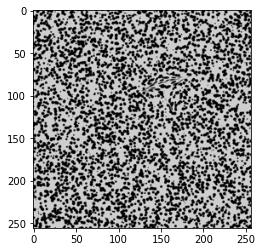

In [16]:
plt.imshow(images[0].detach().cpu().permute(1, 2, 0))

out = finetune_mask_rcnn(images)

/om2/user/yyf/CommonFate/scenes/test_noise/superquadric_2/scene_003
torch.Size([12, 4]) torch.Size([6, 2, 4])


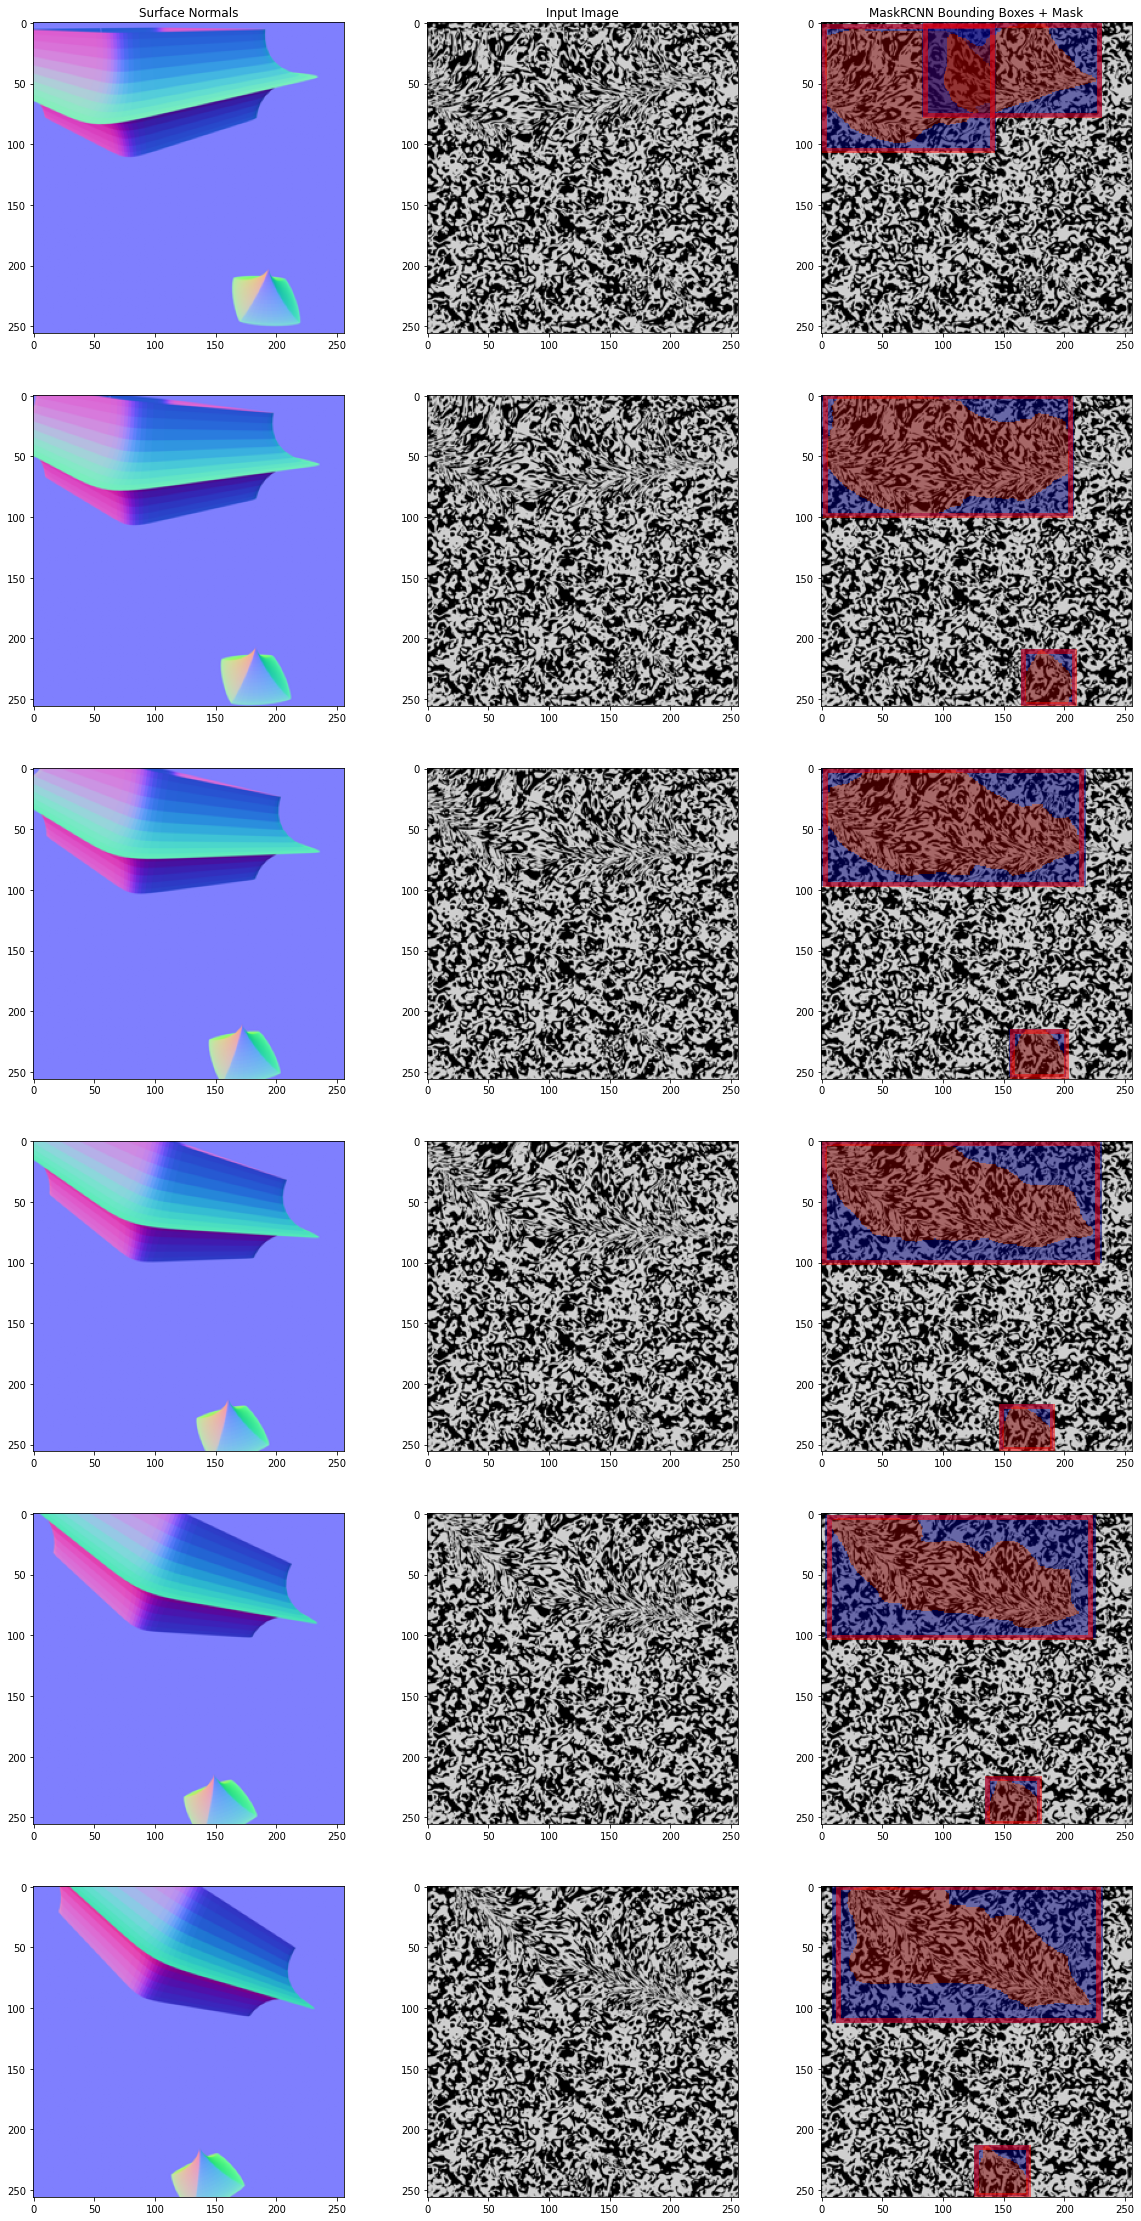

/om2/user/yyf/CommonFate/scenes/test_noise/superquadric_2/scene_003
torch.Size([12, 4]) torch.Size([6, 2, 4])


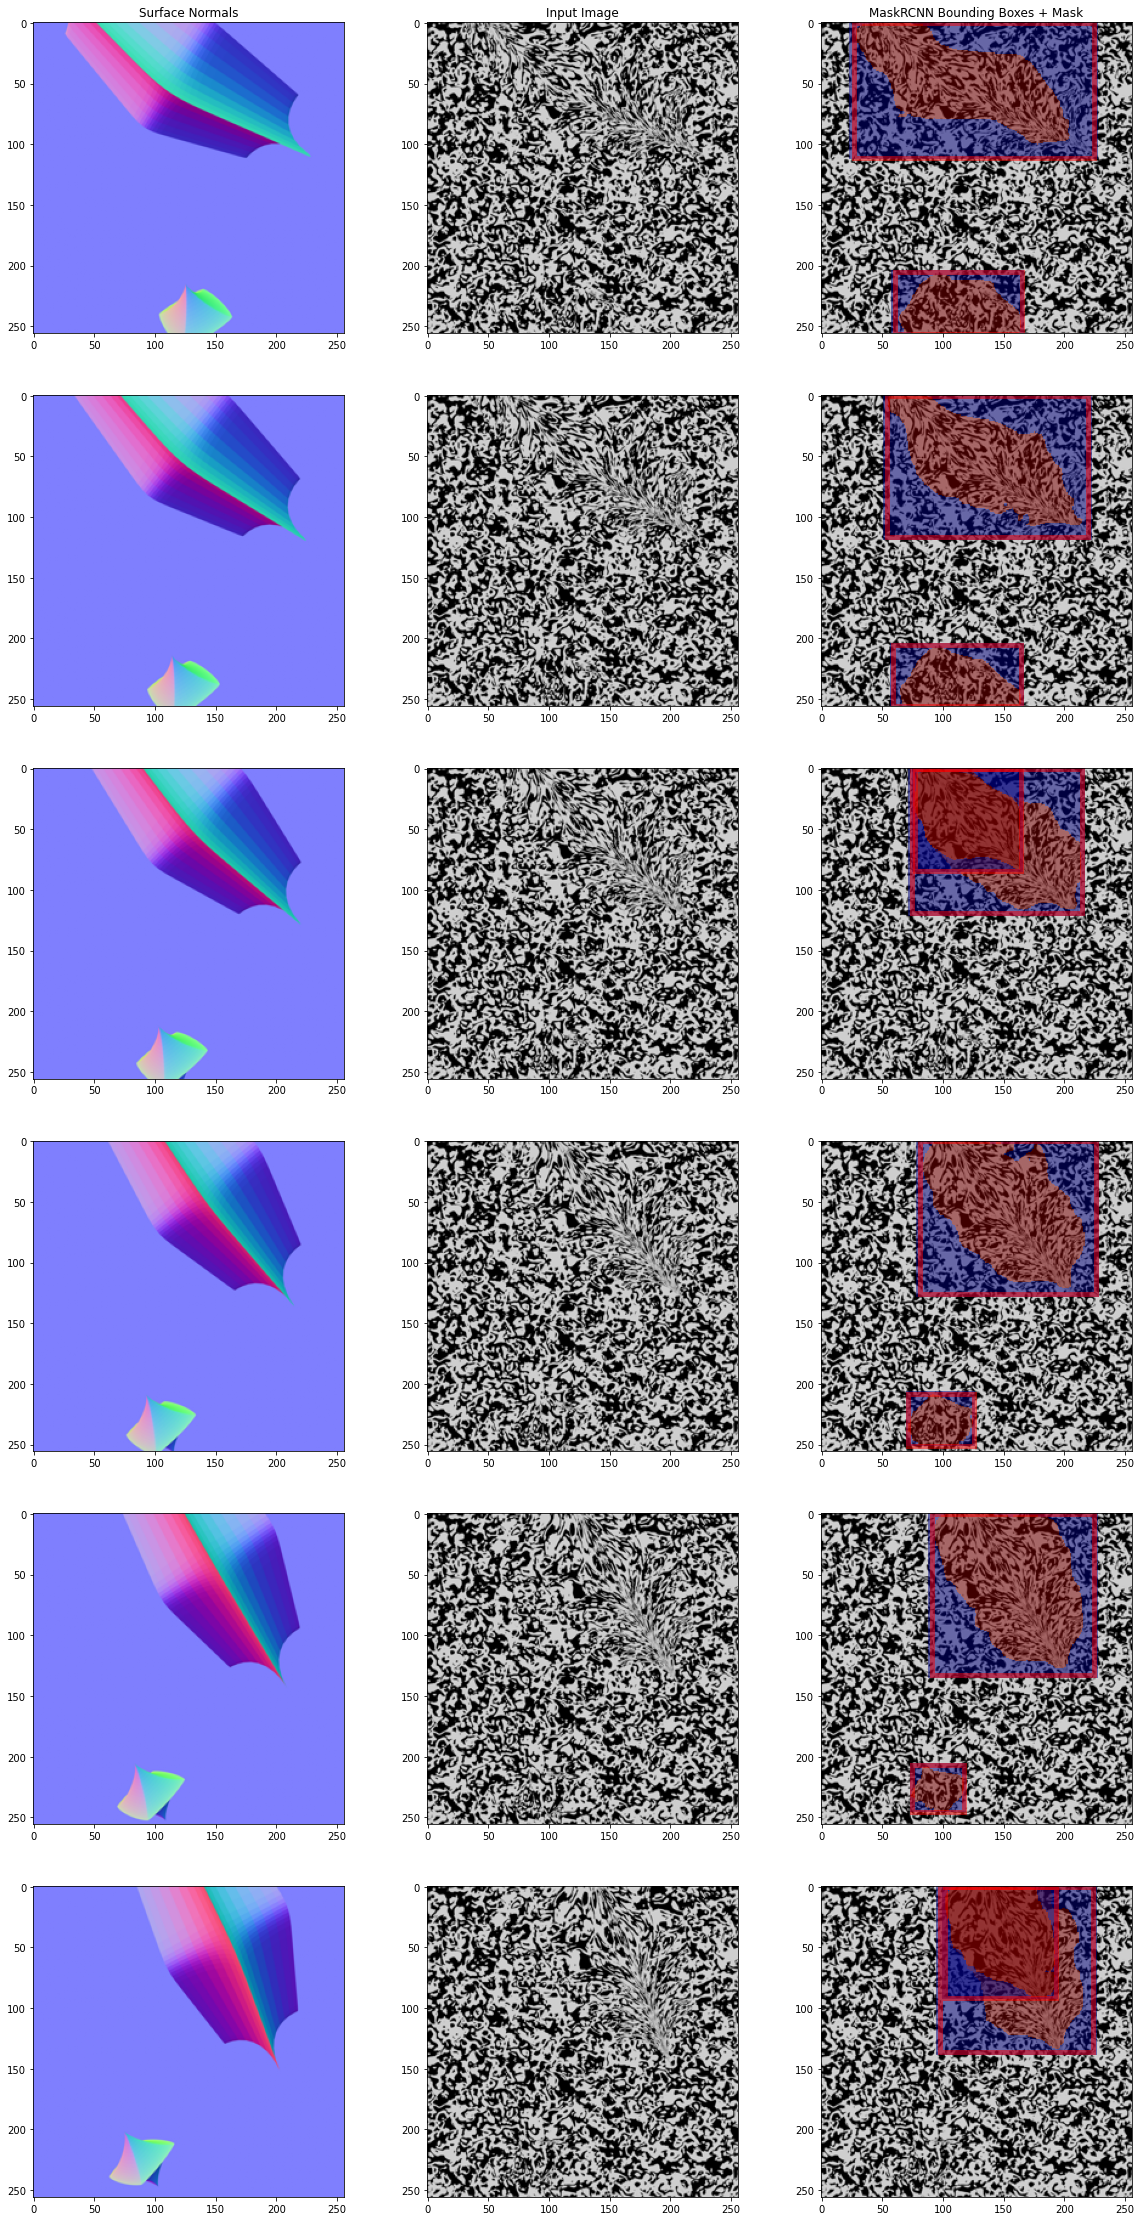

/om2/user/yyf/CommonFate/scenes/test_noise/superquadric_2/scene_003
torch.Size([12, 4]) torch.Size([6, 2, 4])


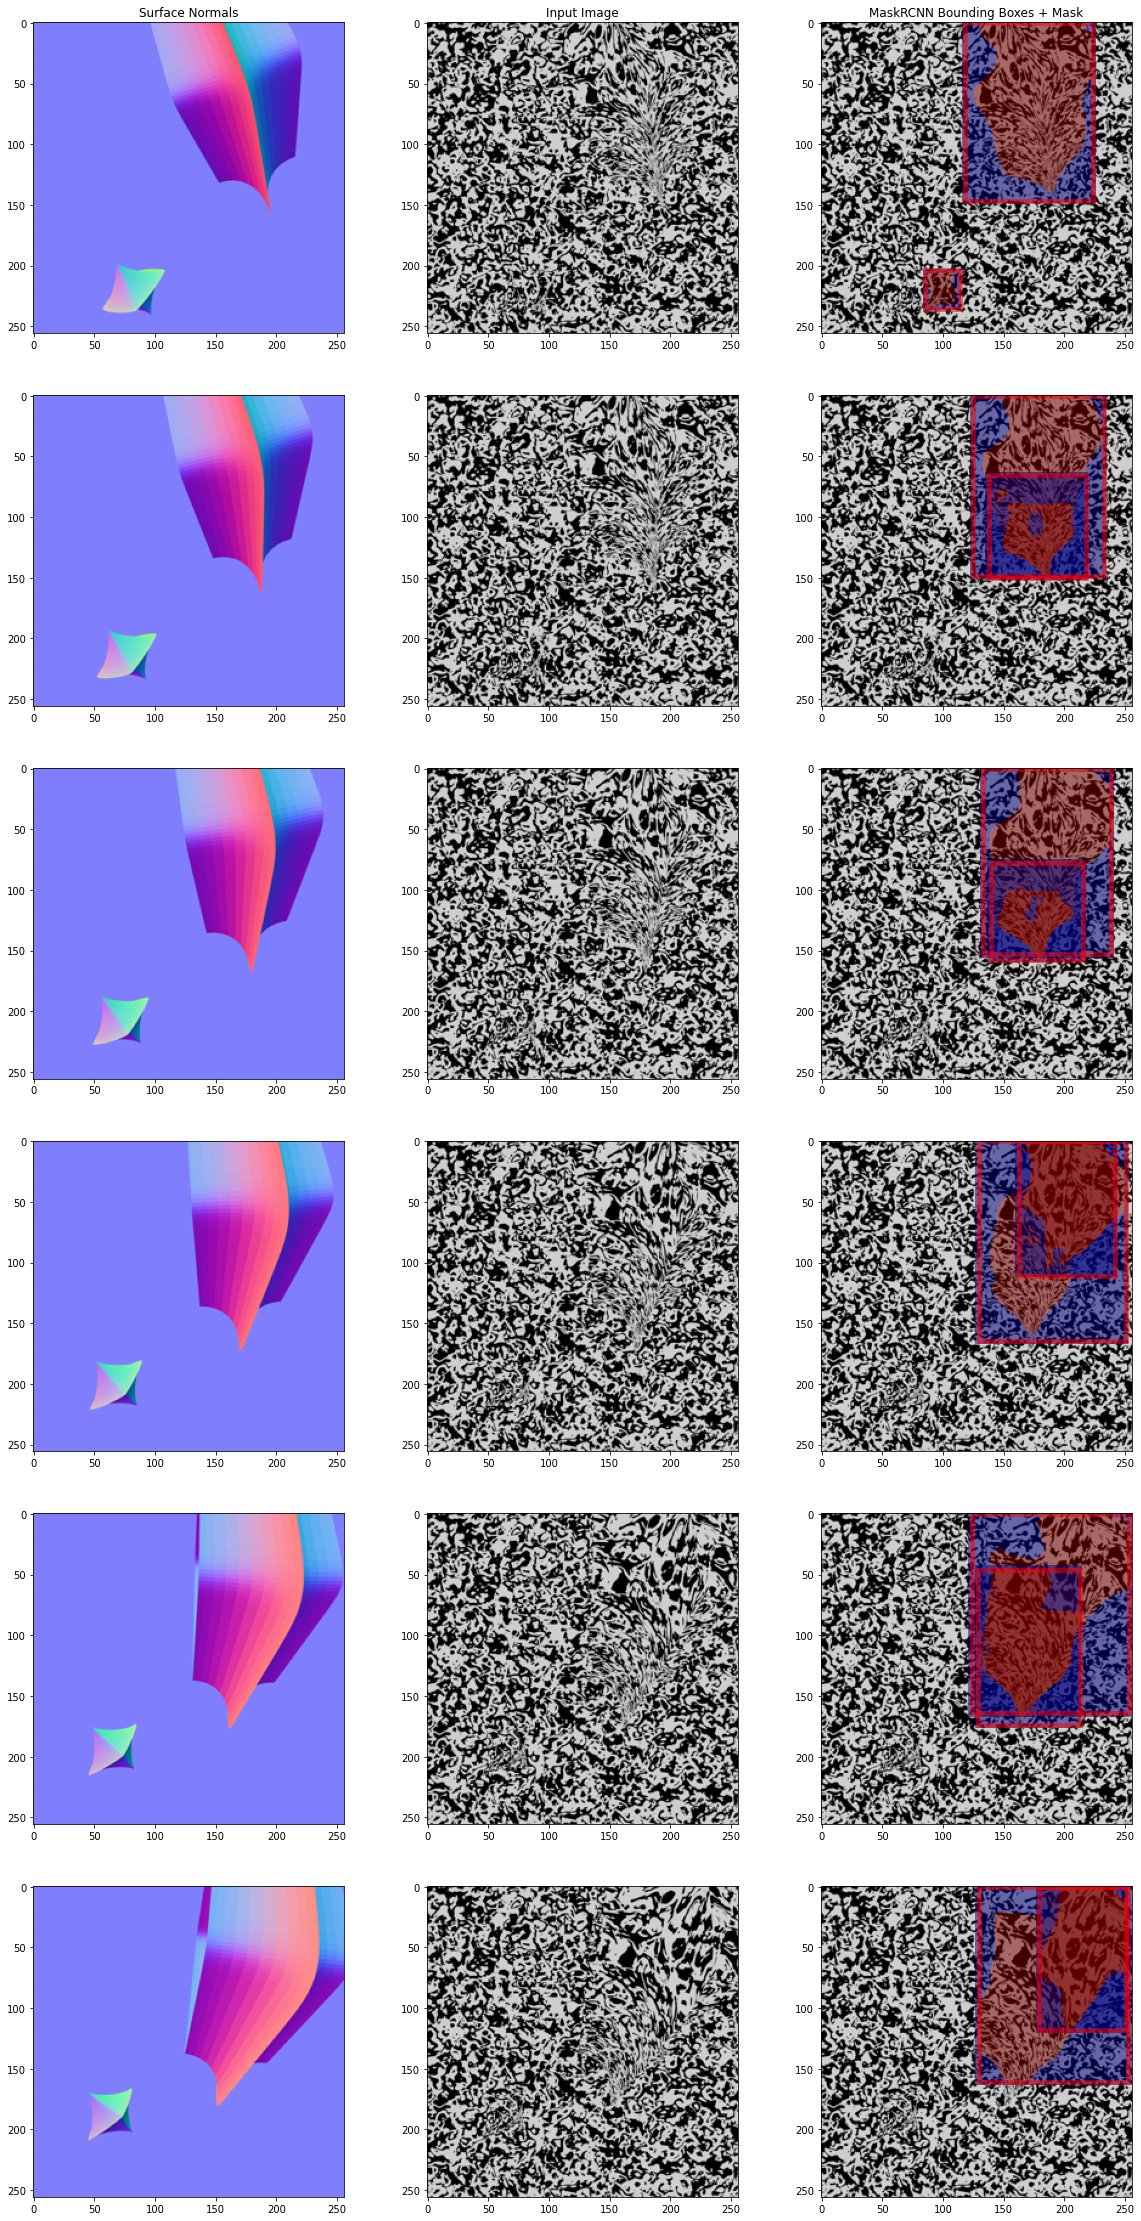

KeyboardInterrupt: 

In [30]:
model = fine_tune_maskrcnn
model.eval()
model.to("cuda")
mIOU = []

for i in range(130, len(test_data)):
    batch = test_data.__getitem__(i)
    images = batch[0].to("cuda")
    masks = batch[1]["masks"].to("cuda")
    bbox = batch[1]["boxes"].to("cuda").type(torch.uint8)
    normals = batch[1]["normals"].permute((0, 2, 3, 1))
    output = model(images)

    scene_dir = batch[1]["scene_dir"]
    print(scene_dir)
    k = int(scene_dir.split("/")[-2].split("_")[-1])

    # Process masks
    for i in range(len(output)):
        output[i]["masks"] = output[i]["masks"][output[i]["scores"].topk(k)[1]].detach().cpu().numpy()
        output[i]["masks"] = np.ma.masked_where(output[i]["masks"] == 0, output[i]["masks"])

    
    # Process boxes
    for i in range(len(output)):
        output[i]["boxes"] = output[i]["boxes"][output[i]["scores"].topk(k)[1]]

                                                                             
    print(pred_boxes.shape, bbox.shape)
    #     m_iou = (pred_boxes | bbox) / (pred_boxes & bbox)
    #     mIOU.append(m_iou)

    plot(images.detach().cpu().numpy(), pred_boxes=[o["boxes"].detach().cpu().numpy() for o in output], 
         masks=[o["masks"] > 0.5 for o in output], 
         normals=normals)


In [ ]:
images, targets = test_data.__getitem__(244)
normals = targets["normals"].detach().cpu().numpy().transpose((0, 2, 3, 1))
base_model = get_model_instance_segmentation(2).to("cuda")
base_model.eval()
base_output = base_model(images.to("cuda"))
k=2

for i in range(len(base_output)):
    base_output[i]["masks"] = base_output[i]["masks"][output[i]["scores"].topk(k)[1]].detach().cpu().numpy()
    base_output[i]["masks"] = np.ma.masked_where(base_output[i]["masks"] == 0, base_output[i]["masks"])
    
print(base_output[0]["masks"].shape)
for i in range(len(output)):
    base_output[i]["boxes"] = base_output[i]["boxes"][base_output[i]["scores"].topk(k)[1]]
    
plot(images.detach().cpu().numpy(), 
     pred_boxes=[o["boxes"].detach().cpu().numpy() for o in base_output], 
     masks=[o["masks"] > 0.5 for o in base_output], normals=normals)   
